In [93]:
# The code was removed by Watson Studio for sharing.

In [162]:
from numpy.random import seed

seed(1)

from tensorflow import set_random_seed

set_random_seed(2)

import numpy as np
import keras
import pandas as pd
from keras.layers import Dense, Dropout, Input, Embedding, Flatten, LSTM
from keras.models import Model,Sequential
from keras.optimizers import SGD, Adam
import matplotlib.pylab as plt
from sklearn.metrics import classification_report
import itertools
import collections
import h5py as h5
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score # multilabel metrics

In [95]:
## load features set

In [96]:
my_file = project.get_file('selected_features_2005_to_2017.csv')
crimes=pd.read_csv(my_file,error_bad_lines=False)

In [97]:
crimes.head()

,Date,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,Location Description Number,Community Area,hour,Day of Week,Business Hour,Business Day,Day of Month,Beat,District,Ward
0,2006-04-02 13:00:00,0,0,0,0,0,0,0,0,0,...,1,11.0,13,6,1,0,2,1622,16.0,45.0
1,2006-02-26 13:40:48,0,0,0,0,0,0,0,0,0,...,2,42.0,13,6,1,0,26,321,3.0,20.0
2,2006-04-05 18:45:00,0,0,1,0,0,0,0,0,0,...,1,17.0,18,2,0,1,5,1633,16.0,38.0
3,2006-02-17 21:03:14,0,0,0,0,0,0,0,0,0,...,2,65.0,21,4,0,1,17,822,8.0,13.0
4,2006-03-30 22:30:00,0,1,0,0,0,0,0,0,0,...,1,67.0,22,3,0,1,30,734,7.0,17.0


In [98]:
## setting train and test data

In [99]:
crimes.index = pd.DatetimeIndex(crimes.Date)
crimes_2005_2016 = crimes.loc['2005':'2016']
crimes_2017 = crimes.loc['2017']

In [100]:
print('Number of observations in the training data:', len(crimes_2005_2016))
print('Number of observations in the test data:',len(crimes_2017))

Number of observations in the training data: 4045599
Number of observations in the test data: 10551


In [101]:
crimes_2017.head()

,Date,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,Location Description Number,Community Area,hour,Day of Week,Business Hour,Business Day,Day of Month,Beat,District,Ward
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 01:00:00,2017-01-01 01:00:00,0,0,1,0,0,0,0,0,0,...,3,8.0,1,6,0,0,1,1824,18.0,42.0
2017-01-01 01:23:00,2017-01-01 01:23:00,0,0,0,0,0,0,0,0,0,...,2,71.0,1,6,0,0,1,613,6.0,21.0
2017-01-01 00:01:00,2017-01-01 00:01:00,0,0,0,0,0,0,1,0,0,...,1,42.0,0,6,0,0,1,314,3.0,5.0
2017-01-01 00:00:00,2017-01-01 00:00:00,0,0,0,0,0,0,1,0,0,...,2,69.0,0,6,0,0,1,324,3.0,5.0
2017-01-01 00:00:00,2017-01-01 00:00:00,0,0,1,0,0,0,0,0,0,...,1,68.0,0,6,0,0,1,722,7.0,20.0


In [102]:
crimes_2005_2016.columns

Index(['Date', 'ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE',
       'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT', 'NARCOTICS',
       'NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'OBSCENITY', 'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC INDECENCY',
       'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ROBBERY', 'SEX OFFENSE',
       'STALKING', 'THEFT', 'WEAPONS VIOLATION', 'Date.1',
       'Primary Type in number', 'Location Description Number',
       'Community Area', 'hour', 'Day of Week', 'Business Hour',
       'Business Day', 'Day of Month', 'Beat', 'District', 'Ward'],
      dtype='object')

In [103]:
# separate features and output of training data
features_train = crimes_2005_2016[["hour", "Day of Week", "Primary Type in number", "Community Area", "Business Hour",
                             "Business Day"]]
# transform to categorical encoding
y = crimes_2005_2016["Location Description Number"]
y_train = keras.utils.to_categorical(y, num_classes=4)

In [121]:
y.value_counts()

2    2046059
1    1444468
3     555072
Name: Location Description Number, dtype: int64

In [106]:
features_train.head()

,hour,Day of Week,Primary Type in number,Community Area,Business Hour,Business Day
Date,,,,,,
2006-04-02 13:00:00,13,6,24,11.0,1,0
2006-02-26 13:40:48,13,6,17,42.0,1,0
2006-04-05 18:45:00,18,2,2,17.0,0,1
2006-02-17 21:03:14,21,4,17,65.0,0,1
2006-03-30 22:30:00,22,3,1,67.0,0,1


In [107]:
# separate features and output of test data
features_test = crimes_2017[["hour", "Day of Week", "Primary Type in number", "Community Area", "Business Hour",
                             "Business Day"]]
y_2017 = crimes_2017["Location Description Number"]
y_test = keras.utils.to_categorical(y_2017, num_classes=4)

## Model initialize

In [123]:
# y_ints = [y.argmax() for y in y_train]

In [125]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_ints),
#                                                  y_ints)

In [137]:
#!pip install --upgrade keras==2.1.3
time_start = time.clock()

#build neural network model structure1#
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=6, init='glorot_uniform'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu',init='glorot_uniform'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu',init='glorot_uniform'))
#model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

sgd =SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

history=model.fit(np.array(features_train), np.array(y_train),
          epochs=5,batch_size=128,validation_split=0.2, shuffle=True, verbose=1) #class_weight=class_weights

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", input_dim=6, kernel_initializer="glorot_uniform")`
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="glorot_uniform")`
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="glorot_uniform")`


Train on 3236479 samples, validate on 809120 samples
Epoch 1/5
3236479/3236479 [==============================] - 59s 18us/step - loss: 0.8547 - acc: 0.5887 - val_loss: 0.8812 - val_acc: 0.5798
Epoch 2/5
3236479/3236479 [==============================] - 59s 18us/step - loss: 0.8255 - acc: 0.6079 - val_loss: 0.8752 - val_acc: 0.5749
Epoch 3/5
3236479/3236479 [==============================] - 59s 18us/step - loss: 0.8175 - acc: 0.6130 - val_loss: 0.8588 - val_acc: 0.5887
Epoch 4/5
3236479/3236479 [==============================] - 59s 18us/step - loss: 0.8132 - acc: 0.6157 - val_loss: 0.8775 - val_acc: 0.5935
Epoch 5/5
3236479/3236479 [==============================] - 59s 18us/step - loss: 0.8085 - acc: 0.6188 - val_loss: 0.8516 - val_acc: 0.5960


## Model loss function and test data validation

In [138]:
y_pred = model.predict_classes(np.array(features_test), batch_size=32, verbose=0)
#y_pred[y_pred>=0.5] = 1
#y_pred[y_pred<0.5] = 0
print(y_pred.shape)
print(collections.Counter(y_pred))
y_pred = np.array([y_pred])
y_pred = y_pred.transpose()

time_elapsed = (time.clock() - time_start)
print("time to build a model is:", time_elapsed)

(10551,)
Counter({2: 7013, 1: 3068, 3: 470})
time to build a model is: 1114.4900000000052


## Model Evaluation

Confusion matrix, without normalization
[[2082 2123   67]
 [ 647 3720  136]
 [ 339 1170  267]]
Normalized confusion matrix
[[ 0.49  0.5   0.02]
 [ 0.14  0.83  0.03]
 [ 0.19  0.66  0.15]]
             precision    recall  f1-score   support

          1    0.67862   0.48736   0.56730      4272
          2    0.53044   0.82612   0.64606      4503
          3    0.56809   0.15034   0.23776      1776

avg / total    0.59677   0.57521   0.54544     10551



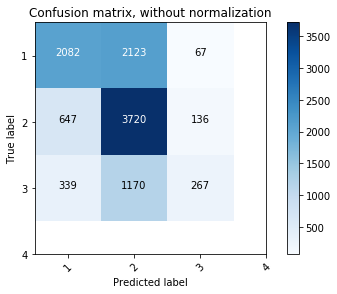

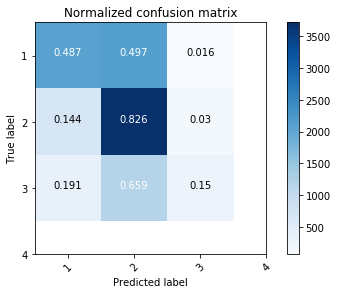

In [140]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
class_names = [1,2,3]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_2017, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


# compute classification report
classificationReport = classification_report(y_2017, y_pred, digits=5)
# classificationReport = classificationReport.to_array()
# np.set_printoptions(precision=2)
print(classificationReport)
plt.show()

#print ("Accuracy:{}".format(accuracy_score(y_2017, y_pred)))

In [ ]:
#0: OTHER
#1: APARTMENT, RESINDENCE
#2: OPEN/PUBLIC SPACES (STREET,ALLEY,SIDEWALK,LOT,PARK,STATION,PUBLIC,PLATFORM)
#3: CLOSED/CORPORATE PLACES (STORE, RESTUARENT, SCHOOL, BUILDING, BAR, OFFICE, BUS, BANK, HOTEL, TRAIN, VEHICLE) 

In [132]:
# Checking for 3 classes as other is not of a big concern.
classificationReport = classification_report(y_2017, y_pred, digits=5)
print(classificationReport)

             precision    recall  f1-score   support

          1    0.67231   0.53886   0.59823      4272
          2    0.53911   0.80657   0.64626      4503
          3    0.61538   0.13514   0.22161      1776

avg / total    0.60588   0.58516   0.55534     10551



In [180]:
# micro avg score
f1_score(y_2017, y_pred, average='micro')

0.5752061415979528

In [155]:
# The code was removed by Watson Studio for sharing.

In [ ]:
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=cos_credentials['apikey'],
    ibm_auth_endpoint=cos_credentials['endpoint'],
    config=Config(signature_version='oauth'),
    endpoint_url=cos_credentials['url'])

In [158]:
## save model to cloud object storage

In [159]:
# save model and weights
model.save('model_gru.h5')

# save matrices
with h5.File('crime_data.h5', 'w') as f:
    f['X_train'] = features_train
    f['X_test'] = features_test
    f['y_train'] = y_train
    f['y_test'] = y_test
    f['y_pred'] = y_pred
    
cos_client.upload_file(Filename='crime_data.h5',Bucket=cos_credentials['bucket'],Key='crime_data.h5')

!ls

a2_m1.json	       a2_m4.json.zip	      my_modelx.h5
a2_m1.json.zip	       a2_m4.json.zip.base64  __pycache__
a2_m1.json.zip.base64  a_yrua4s_anything.log  rklib.py
a2_m2.json	       crime_data_gru.tgz     rklib.pyc
a2_m2.json.zip	       crime_data.h5	      scratch_space
a2_m2.json.zip.base64  crime_data.zip	      sonar.csv
a2_m3.json	       dl4j-snapshot.jar      toronto_part1.csv
a2_m3.json.zip	       model_gru.h5	      toxic.zip
a2_m3.json.zip.base64  model.h5		      watsoniotp.broken.pickle
a2_m4.json	       model.h5.base64	      watsoniotp.healthy.pickle


In [160]:
# zip files and upload to COS
!zip crime_data.zip model_gru.h5 toxic_data.h5
cos_client.upload_file(Filename='crime_data.zip', Bucket=cos_credentials['bucket'], Key='crime_data.zip')


	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (crime_data.zip)
